# Import Packages

In [1]:
import os
import sys
import csv
import random
import platform
import subprocess
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Set Command

In [4]:
os_name = platform.system()
if os_name == "Darwin":
    AES_command = "./AES-CBC-macOS"
    AES_ResultFile = "AES_CBC_macOS.csv"
elif os_name == "Linux":
    AES_command = "./AES-CBC-Linux"
    AES_ResultFile = "AES_CBC_Linux.csv"
elif os_name == "Windows":
    AES_command = "AES-CBC-Windows.exe"
    AES_ResultFile = "AES_CBC_Windows.csv"
else:
    print("OS not supported")
    sys.exit(1)

if not os.path.exists(AES_command):
    print("AES command not found")
    sys.exit(1)

print("AES command: ", AES_command)
print("AES Result File: ", AES_ResultFile)

AES command:  ./AES-CBC-macOS
AES Result File:  AES_CBC_macOS.csv


# Create Input Files

In [3]:
# Create directories
if not os.path.exists("./Container"):
    os.makedirs("./Container")
if not os.path.exists("./Container/Keys"):
    os.makedirs("./Container/Keys")
if not os.path.exists("./Container/Plain"):
    os.makedirs("./Container/Plain")
if not os.path.exists("./Container/Cipher"):
    os.makedirs("./Container/Cipher")
if not os.path.exists("./Container/Recovered"):
    os.makedirs("./Container/Recovered")

# Create a file with random data
def create_file(file_path, size_in_bytes):
    with open(file_path, 'wb') as f:
        random_bytes = bytearray(os.urandom(size_in_bytes))
        for i in range(size_in_bytes):
            random_bytes[i] = random.randint(32, 126)  # ASCII characters from space to tilde
        f.write(random_bytes)

# Create files with sizes from 1KB to 16MB
sizes = [1024, 262144, 524288, 1048576, 8388608, 16777216]

for size in sizes:
    if size < 1048576:
        FileName = f"{size // 1024}KB.txt"
        FilePath = "./Container/Plain/" + FileName
        create_file(FilePath, size)
        print(f"File {FileName} created with size {size/1024} KB")
    else:
        FileName = f"{size // 1048576}MB.txt"
        FilePath = "./Container/Plain/" + FileName
        create_file(FilePath, size)
        print(f"File {FileName} created with size {size/1048576} MB")

File 1KB.txt created with size 1.0 KB
File 256KB.txt created with size 256.0 KB
File 512KB.txt created with size 512.0 KB
File 1MB.txt created with size 1.0 MB
File 8MB.txt created with size 8.0 MB
File 16MB.txt created with size 16.0 MB


# Run AES Test

In [3]:
KeyDirectory = "./Container/Keys/"
PlainDirectory = "./Container/Plain/"
PlaintextFiles = os.listdir(PlainDirectory)
CipherDirectory = "./Container/Cipher/"
RecoveredDirectory = "./Container/Recovered/Recovered_"

KeySizes = [128, 192, 256]
defaultloops = 556

def GenarateKey(keysize):
    command = f"{AES_command} keygen {keysize} {KeyDirectory}key{keysize}.bin {KeyDirectory}iv.bin"

    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    
    return output.decode("utf-8"), error.decode("utf-8")

def AES_Excution(keysize, file):
    EncryptCommand = f"{AES_command} encrypt {KeyDirectory}key{keysize}.bin {KeyDirectory}iv.bin {PlainDirectory}{file} {CipherDirectory}cipher.bin"
    DecryptCommand = f"{AES_command} decrypt {KeyDirectory}key{keysize}.bin {KeyDirectory}iv.bin {CipherDirectory}cipher.bin {RecoveredDirectory}{file}"
    
    process = subprocess.Popen(EncryptCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    EncryptionTime = output.decode("utf-8")
    EncryptionError = error.decode("utf-8")

    process = subprocess.Popen(DecryptCommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, error = process.communicate()
    DecryptionTime = output.decode("utf-8")
    DecryptionError = error.decode("utf-8")

    return EncryptionTime, EncryptionError, DecryptionTime, DecryptionError

with open(AES_ResultFile, "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["KeySize", "File", "Encryption_Time", "Decryption_Time"])
    
    for keysize in KeySizes:
        # Genarate Key and IV
        output, error = GenarateKey(keysize)
        if error:
            print(error)
            sys.exit(1)
        print(f"[ {keysize} | CBC ]")

        for file in PlaintextFiles:
            print(f"   Executing {file}")
            i = 0
            while i < defaultloops:
                # AES Encryption and Decryption
                EncryptionTime, EncryptionError, DecryptionTime, DecryptionError = AES_Excution(keysize, file)
                if EncryptionError:
                    print(f"*** Encryption error for {file}: {EncryptionError}")
                    sys.exit(1)
                if DecryptionError:
                    print(f"*** Decryption error for {file}: {DecryptionError}")
                    sys.exit(1)
                # Write results to file
                writer.writerow([keysize, file, EncryptionTime, DecryptionTime])

                i = i + 1
                    
print("Successfully run AES test!")

[ 128 | CBC ]
   Executing 1KB.txt
   Executing 1MB.txt
   Executing 256KB.txt
   Executing 512KB.txt
   Executing 16MB.txt
   Executing 8MB.txt
[ 192 | CBC ]
   Executing 1KB.txt
   Executing 1MB.txt
   Executing 256KB.txt
   Executing 512KB.txt
   Executing 16MB.txt
   Executing 8MB.txt
[ 256 | CBC ]
   Executing 1KB.txt
   Executing 1MB.txt
   Executing 256KB.txt
   Executing 512KB.txt
   Executing 16MB.txt
   Executing 8MB.txt
Successfully run AES test!


# Compare the results of the different OS and Input Sizes

AES CBC Results:
   Algorithm Mode       OS Input_File  Encryption_Mean  Decryption_Mean
0        AES  CBC    Linux    1KB.txt            2.808            2.823
1        AES  CBC    Linux  256KB.txt            8.069            7.581
2        AES  CBC    Linux  512KB.txt           13.714           13.190
3        AES  CBC    Linux    1MB.txt           25.302           24.859
4        AES  CBC    Linux    8MB.txt          172.820          164.950
5        AES  CBC    Linux   16MB.txt          331.254          315.734
6        AES  CBC    macOS    1KB.txt            0.295            0.291
7        AES  CBC    macOS  256KB.txt            0.878            0.689
8        AES  CBC    macOS  512KB.txt            1.452            0.964
9        AES  CBC    macOS    1MB.txt            2.574            1.781
10       AES  CBC    macOS    8MB.txt           19.228           11.857
11       AES  CBC    macOS   16MB.txt           38.772           23.824
12       AES  CBC  Windows    1KB.txt          

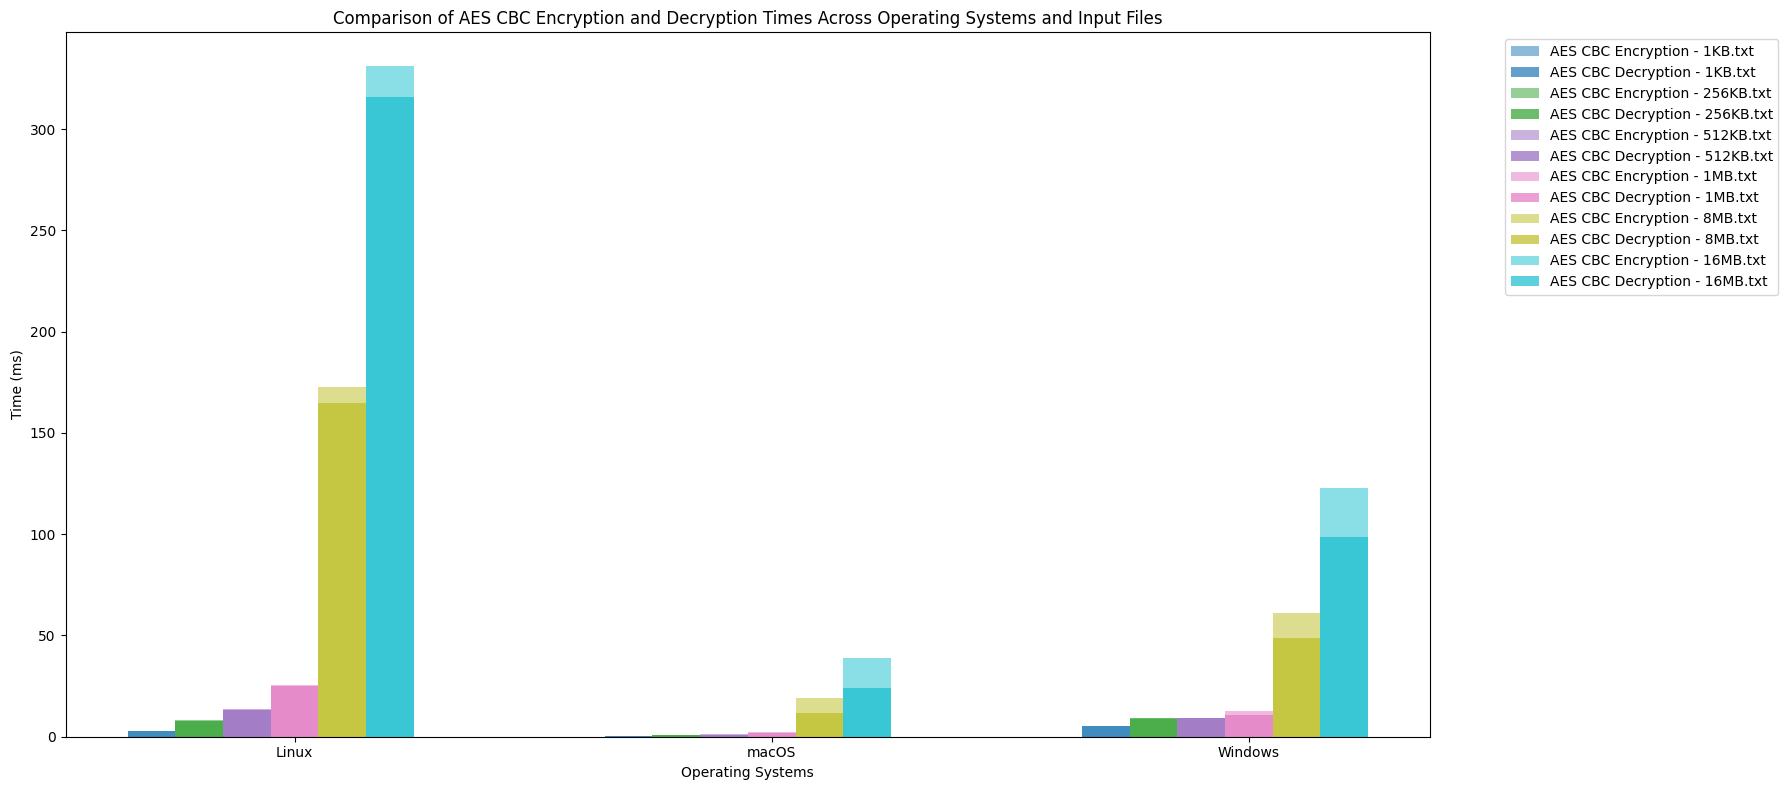

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# CSV files containing the results of the AES CBC tests
files = {
    'AES_Linux': './AES_CBC_Linux.csv',
    'AES_macOS': './AES_CBC_macOS.csv',
    'AES_Windows': './AES_CBC_Windows.csv',
}

# Initialize lists to store the results
results_aes_cbc = []

# Read the results from the CSV files
for label, file_path in files.items():
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        if not df.empty:
            # Calculate the mean encryption and decryption times for each input file
            for file_name in ['1KB.txt', '256KB.txt', '512KB.txt', '1MB.txt', '8MB.txt', '16MB.txt']:
                file_df = df[df['File'] == file_name]
                
                encryption_mean = round(file_df['Encryption_Time'].mean(), 3)
                decryption_mean = round(file_df['Decryption_Time'].mean(), 3)

                # Save the results to the AES CBC list
                algorithm, os_name = label.split('_')
                results_aes_cbc.append({
                    'Algorithm': algorithm,
                    'Mode': 'CBC',
                    'OS': os_name,
                    'Input_File': file_name,
                    'Encryption_Mean': encryption_mean,
                    'Decryption_Mean': decryption_mean
                })

# Convert the results list to a DataFrame
results_df_aes_cbc = pd.DataFrame(results_aes_cbc)

# Check if the DataFrame is empty
if results_df_aes_cbc.empty:
    print("No data available for AES CBC.")
else:
    # Show AES CBC results
    print("AES CBC Results:")
    print(results_df_aes_cbc)
    print()

    # Create a bar chart comparing AES CBC encryption and decryption times for each operating system and input file
    fig, ax = plt.subplots(figsize=(18, 8))
    width = 0.6  # Width of the bars
    os_list = results_df_aes_cbc['OS'].unique()
    x_aes_cbc = np.arange(len(os_list))

    # Create colors for each input file
    colors_aes_cbc = cm.tab10(np.linspace(0, 1, len(results_df_aes_cbc['Input_File'].unique())))

    # Plot the bar chart for AES CBC encryption and decryption times
    for i, file_name in enumerate(results_df_aes_cbc['Input_File'].unique()):
        aes_encryption = results_df_aes_cbc[results_df_aes_cbc['Input_File'] == file_name]['Encryption_Mean']
        aes_decryption = results_df_aes_cbc[results_df_aes_cbc['Input_File'] == file_name]['Decryption_Mean']
        bar_pos = x_aes_cbc - width/2 + i * width/len(results_df_aes_cbc['Input_File'].unique())
        ax.bar(bar_pos, aes_encryption, width/len(results_df_aes_cbc['Input_File'].unique()), label=f'AES CBC Encryption - {file_name}', color=colors_aes_cbc[i], alpha=0.5)
        ax.bar(bar_pos, aes_decryption, width/len(results_df_aes_cbc['Input_File'].unique()), label=f'AES CBC Decryption - {file_name}', color=colors_aes_cbc[i], alpha=0.7)

    # Add labels and title for AES CBC
    ax.set_xlabel('Operating Systems')
    ax.set_ylabel('Time (ms)')
    ax.set_title('Comparison of AES CBC Encryption and Decryption Times Across Operating Systems and Input Files')
    ax.set_xticks(x_aes_cbc)
    ax.set_xticklabels(os_list)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()
